In [36]:
from sympy import symbols, init_printing, pi, sqrt, solveset, Eq
from scipy.constants import c
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from ipywidgets.widgets import (
    interactive_output,
    BoundedFloatText,
    BoundedIntText,
    HBox,
    VBox,
    IntRangeSlider,
    Text,
    Button,
    Label,
    Layout
)

from IPython.display import display
import datetime, os
from os.path import isdir
from pathlib import Path

In [2]:
init_printing()
save_location = Path(r"D:\SurfDrive\backup_for_surfacePro\Work\THz_setup\Simulations")

# Defining functions
def ghz_cm(x):
    """
    Input: freq in GHZ
    Output: freq in cm
    """
    return c * 1e2 / x * 1e-9

cm_ghz = lambda x: c*1e-9*1e2/x

print(f"Save location: {save_location}")
save_location.exists()

Save location: D:\SurfDrive\backup_for_surfacePro\Work\THz_setup\Simulations


True

In [3]:
# Symbols
w, lam, w0, z, Z_r = symbols("w, lam, w0, z, Z_r")
M, E, d_in, d_out, w0_in, w0_out, f, f0 = symbols('M, E, d_in, d_out, w0_in, w0_out, f, f0')

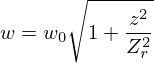

In [4]:
## Formulas

# Beam radius
Wz = Eq(w, w0 * sqrt(1 + (z / Z_r) ** 2))
Wz

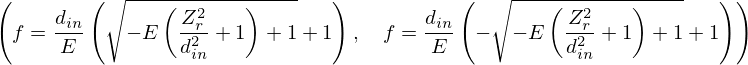

In [5]:
# Focal length
fp = Eq(f, Z_r*(d_in/(E*Z_r))*(1+sqrt(1-E*(1+(d_in/Z_r)**-2)))) # positive sign but output is negative focus
fm = Eq(f, Z_r*(d_in/(E*Z_r))*(1-sqrt(1-E*(1+(d_in/Z_r)**-2)))) # negative sign but output is positive focus

fp, fm

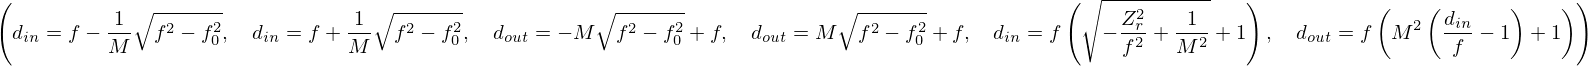

In [6]:
# Input distance
eq_din_m = Eq(d_in, f - sqrt(f ** 2 - f0 ** 2) / M) # Negative sign
eq_din_p = Eq(d_in, f + sqrt(f ** 2 - f0 ** 2) / M) # Positive sign

# output distance
eq_dout_m = Eq(d_out, f - sqrt(f ** 2 - f0 ** 2) * M) # Negative sign
eq_dout_p = Eq(d_out, f + sqrt(f ** 2 - f0 ** 2) * M) # Positive sign
# NOTE: use same sign for output distance as chosed for input distane

# Input and output distances in-terms of each other
eq_dout2 = Eq(d_out, f * (1 + (M ** 2 * (d_in / f - 1))))
eq_din2 = Eq(d_in, f * (1 + sqrt(M ** -2 - (Z_r / f) ** 2)))

eq_din_m, eq_din_p, eq_dout_m, eq_dout_p, eq_din2, eq_dout2, 

In [55]:
class simulation:
    def __init__(self):

        # Beam properties
        W_in = BoundedFloatText(
            value=0.34, min=0.1, max=1, step=0.01, description="$w0_{in}$: "
        )

        D_in = BoundedFloatText(
            value=20, min=5, max=30, step=0.1, description="$d_{in}$: "
        )
        
        To_use = BoundedIntText(
            value=0, min=0, max=2, step=1, description="$F(w_0)$ to use: "
        )

        # Figure Properties
        Width = BoundedFloatText(value=15, min=5, max=25, step=1, description="width")
        Height = BoundedFloatText(value=5, min=5, max=25, step=1, description="height")
        Dpi = BoundedFloatText(value=100, min=70, max=300, step=1, description="Dpi")

        # Widget to save
        self.save_name = Text(value="THz_simulation_325-1100GHz")
        save_button = Button(description="Save", layout={"width": "300px"})
        save_button.on_click(self.save_plot)
        self.print_save = Label(value="Status: ")

        # Widget arrangements
        row1 = HBox([W_in, D_in, To_use])
        row2 = HBox([Width, Height, Dpi])
        row3 = VBox([self.save_name, save_button, self.print_save])

        # Plot output
        out = interactive_output(
            self.plot,
            {"w1": W_in, "d1": D_in, "to_use": To_use, "width": Width, "height": Height, "dpi": Dpi},
        )

        # widget display
        display(VBox([row1, row2, out, row3]))

    def save_plot(self, event):

        try:
            if not save_location.exists():
                save_location.mkdir()

            self.fig.savefig(save_location.joinpath(self.save_name.value + ".png"))
            self.fig.savefig(save_location.joinpath(self.save_name.value + ".pdf"))

            t = datetime.datetime.now()
            self.print_save.value = (
                f'File "{self.save_name.value}.png" Saved; {t.ctime()}'
            )

        except:
            self.print_save.value = "Error Occured."

    def plot(self, w1, d1, to_use, width, height, dpi):

        wn_size = 5
        wz_size = 20
        d_trap = -1.4

        # 3-sets of wavelength range for 3-different horn
        wn_set1 = np.linspace(325, 500, wn_size)
        wn_set2 = np.linspace(500, 750, wn_size)
        wn_set3 = np.linspace(750, 1100, wn_size)
        wn_list = np.array([wn_set1, wn_set2, wn_set3])

        # 3-sets of horns waist for different wavelength
        w0_out_list = [0.15, 0.099, 0.066]

        # Defining figure:
        self.fig = plt.figure(figsize=(width, height), dpi=dpi)
        nrows, ncols = 1, 3

        ax1 = self.fig.add_subplot(nrows, ncols, 1)
        ax2 = self.fig.add_subplot(nrows, ncols, 2, sharey=ax1)
        bx1 = self.fig.add_subplot(nrows, ncols, 3)

        '''ax3 = self.fig.add_subplot(nrows, ncols, 4, sharex=ax1)
        ax4 = self.fig.add_subplot(nrows, ncols, 5, sharey=ax3)
        bx2 = self.fig.add_subplot(nrows, ncols, 6)

        ax5 = self.fig.add_subplot(nrows, ncols, 7, sharex=ax1)
        ax6 = self.fig.add_subplot(nrows, ncols, 8, sharey=ax5)
        bx3 = self.fig.add_subplot(nrows, ncols, 9)'''

        for ax in self.fig.axes:
            ax.grid()

        ##########################################################################################
        
        # opening log file
        t = datetime.datetime.now()
        log_file = open(f"./Simulations/log_file_{to_use}.txt", "w")
        log_file.write(f"Gaussian Simulation: {t.ctime()}\n\n")
        log_file.write("##########################################################################################\n")

        # Focal length and d_out in-use (Taking optimal focal length for the longest wn)
        
        w0_out_in_use = w0_out_list[to_use]
        wn_in_use = wn_list[to_use, 0]
        
        M_in_use = w0_out_in_use / w1
        zc_in_use = np.pi * w1 ** 2 / ghz_cm(wn_in_use)
        
        f_positive = float(
            fm.subs({d_in: d1, E: (1 - M_in_use ** -2), Z_r: zc_in_use}).rhs
        )
        f_negative = float(
            fp.subs({d_in: d1, E: (1 - M_in_use ** -2), Z_r: zc_in_use}).rhs
        )
        
        opt_d2 = float(eq_dout2.subs({f:f_positive, M:M_in_use, d_in:d1}).rhs)
        print(f_positive, opt_d2)
        
        log_file.write(f"Focii:\nf(+ve): {f_positive:.2f}; f(-ve): {f_negative:.2f}\n\n")
        
        
        ##########################################################################################
        
        colors = "C0, C1, C2, C3, C4, C5, C6, C7, C8, C9".split(", ")
        mrkr = [".-", "x-", "--"]
        
        d1_beam = []
        d2_beam = []
        
        d1_distance = []
        d2_distance = []
        
        ##########################################################################################
        log_file.write("##########################################################################################\n\n")
        
        for num, w0_out_ in enumerate(w0_out_list):
            
            log_file.write(f"w0_out: {w0_out_}cm\n\n")
            
            d1_beam_temp = []
            d2_beam_temp = []
            
            d1_distance_temp = []
            d2_distance_temp = []
            
            #################################################################################
            
            for c, wn in enumerate(wn_list[num]):
                
                log_file.write(f"Frequency: {wn}GHz\n")
                
                #################################################################################
                # optimised calculation
                temp_f0 = (np.pi * w1 * w0_out_) / ghz_cm(wn)
                M_ = w0_out_/w1
                
                temp_d1 = float(eq_din_p.subs({M: M_, f0: temp_f0, f: f_positive}).rhs)
                temp_d2 = float(eq_dout_p.subs({M: M_, f0: temp_f0, f: f_positive}).rhs)
                
                #################################################################################
                # d_in beam optimised
                d1_beam_array = np.linspace(temp_d1-d1+d_trap, temp_d1, wz_size)
                zr1 = (np.pi*w1**2)/ghz_cm(wn)
                
                d1_beam_calculation = np.array([float(
                    Wz.subs({w0:w1, Z_r:zr1, z:i}).rhs
                ) for i in d1_beam_array])
                
                #################################################################################
                # d_out beam optimised
                d2_beam_array = np.linspace(0, temp_d2, wz_size)
                zr2 = (np.pi*w0_out_**2)/ghz_cm(wn)
                
                d2_beam_calculation = np.array([float(
                    Wz.subs({w0:w0_out_, Z_r:zr2, z:i}).rhs
                ) for i in d2_beam_array])
                
                #################################################################################
               
                # Plotting
                d1_plot = np.linspace(d_trap, d1, wz_size)
                d2_plot = np.linspace(opt_d2-temp_d2, opt_d2, wz_size)
                
                ax1.plot(d2_plot, d2_beam_calculation, colors[c]+mrkr[num], zorder=1, label=f"{wn:.1f}GHz")
                ax1.plot(d2_plot, -d2_beam_calculation, colors[c]+mrkr[num], zorder=1)
                
                ax2.plot(d1_plot, d1_beam_calculation, colors[c]+mrkr[num], zorder=1)
                ax2.plot(d1_plot, -d1_beam_calculation, colors[c]+mrkr[num], zorder=1)
                
                #################################################################################
                 # Writing log file
                log_file.write(f"d_in:\n{d1_beam_array}\nd_in_beam: {d1_beam_calculation}\n\n")
                log_file.write(f"d_out:\n{d2_beam_array}\nd_out_beam: {d2_beam_calculation}\n\n")
                
                #################################################################################
                # Appending temp values
                d1_distance_temp.append(temp_d1)
                d2_distance_temp.append(temp_d2)
                
                d1_beam_temp.append(d1_beam_calculation)
                d2_beam_temp.append(d2_beam_calculation)
                
                
                
                #################################################################################
            #####################################################################################
            log_file.write("##########################################################################################\n\n")
            
            # Appending main values
            d1_distance.append(d1_distance_temp)
            d2_distance.append(d2_distance_temp)
            
            d1_beam.append(d1_beam_temp)
            d2_beam.append(d2_beam_temp)

            ######################################################################################
        ##########################################################################################
        # Making array
        d1_distance = np.array(d1_distance)
        d2_distance = np.array(d2_distance)
        
        d1_beam = np.array(d1_beam)
        d2_beam = np.array(d2_beam)
        
        ##########################################################################################
        log_file.write(f"w0_out_list: {w0_out_list}\n\n")
        log_file.write(f"Frequency list:\n{wn_list}\n\n")
        log_file.write(f"d_out: (Calibrated)\n{d2_distance}\n\n")
        log_file.write(f"Mirror Diameter: >= {3*d1_beam[0, 0, -1]:.2f}cm\n(since longest wavelength beam waist at mirror is {d1_beam[0, 0, -1]:.2f}cm)\n\n")
        
        ##########################################################################################
        
        ax1.legend(ncol=3, fontsize=7)
        ax2.legend(title=f"f_+ = {f_positive:.2f}cm\nf_- = {f_negative:.2f}cm")
        
        ax2.set_xlabel('$d_{out}$ (cm)')
        ax2.set_xlim(xmax=d1)
        ax2.vlines(0, ymin=-w1, ymax=w1)
        ax2.vlines(d_trap, ymin=-0.43, ymax=0.43)
        ax2.invert_xaxis()

        ax1.set_xlim(xmax=opt_d2)
        ax1.set_xlabel('$d_{in}$ (cm)')
        ax1.set_ylabel('$w(z)$ cm')
        
        for num, w0_out_ in enumerate(w0_out_list):
            bx1.plot(np.arange(wn_size), d1_beam[num][:, 0], colors[num]+mrkr[num], ms=10, label='$w_0^{out}$'+f' = {w0_out_}cm')
            
        bx1.hlines(0.43, xmin=0, xmax=wn_size-1, label='Trap radius')
        bx1.set_xlabel('arbitrary')
        bx1.set_ylabel('w(z): cm (at the entry of trap)')
        bx1.legend()

        plt.tight_layout()
        
        ##########################################################################################
        log_file.write("##########################################################################################\n")
        log_file.write("##########################################################################################\n\n")
        
        log_file.close()
        ##########################################################################################
        self.save_name.value = f"THz_simulation_325-1100GHz_{to_use}"
        
run = simulation()

In [16]:
wn1 = np.linspace(500, 750, 10)
M1 = 0.099

for wn in wn1:
    zr = (np.pi*0.34**2)/ghz_cm(wn)
    temp_d1 = float(eq_din2.subs({f:6.29, M:M1/0.34, Z_r:zr}).rhs)
    temp_d2 = float(eq_dout2.subs({f:6.29, M:M1/0.34, d_in:temp_d1}).rhs)
    print(f"wn: {wn:.2f}\nd_in: {temp_d1} d_out: {temp_d2}\n")

wn: 500.00
d_in: 27.025479819531792 d_out: 8.048031468090235

wn: 527.78
d_in: 26.924208029541187 d_out: 8.0394452672797

wn: 555.56
d_in: 26.816921219615303 d_out: 8.030349090600776

wn: 583.33
d_in: 26.703524551040736 d_out: 8.020734897272927

wn: 611.11
d_in: 26.583915603582565 d_out: 8.010594003725888

wn: 638.89
d_in: 26.457983849271095 d_out: 7.999917038985346

wn: 666.67
d_in: 26.325610064415976 d_out: 7.988693894821289

wn: 694.44
d_in: 26.186665671713257 d_out: 7.976913669969391

wn: 722.22
d_in: 26.04101200293994 d_out: 7.964564607619502

wn: 750.00
d_in: 25.888499471091194 d_out: 7.9516340252263396



In [17]:
solveset(eq_dout2.subs({f:6.29, M:0.15/0.34, d_out:8.961}), d_in), solveset(eq_dout2.subs({f:6.29, M:0.099/0.34, d_out:8.961}), d_in), solveset(eq_dout2.subs({f:6.29, M:0.066/0.34, d_out:8.961}), d_in)

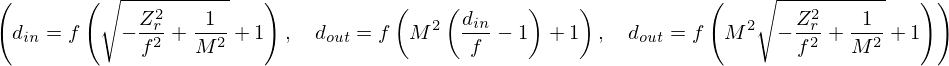

In [18]:
eq_din2, eq_dout2, eq_dout2.subs({d_in:eq_din2.rhs})

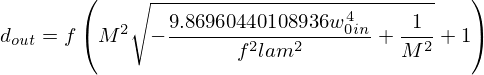

In [19]:
eq_dout3 = eq_dout2.subs({d_in:eq_din2.rhs})
eq_dout3 = eq_dout3.subs({Z_r:np.pi*w0_in**2/lam})
eq_dout3

In [12]:
temp = solveset(eq_dout3.subs({f:6.292094987532539, M:0.099/0.34, d_out:7.95440136, w0_in:0.34}), lam).args[-1]
print(temp)
print(cm_ghz(temp))

0.0399723277155631
750.000000333423


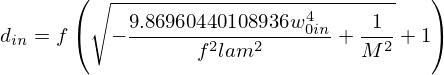

In [13]:
eq_din3 = eq_din2.subs({Z_r:np.pi*w0_in**2/lam})
eq_din3

In [14]:
d1 = 27
temp1 = solveset(eq_din3.subs({f:6.292094987532539, M:0.099/0.34, w0_in:0.34, d_in:d1}), lam).args
temp = solveset(eq_din3.subs({f:6.292094987532539, M:0.099/0.34, w0_in:0.34, d_in:d1}), lam).args[-1]
print(temp1)
print(temp)
print(cm_ghz(temp))

(-0.0588047674276047, 0.0588047674276047)
0.0588047674276047
509.809784332671
